# House Connection Forecast DRF
This notebook evaluates forecasting the house connection power consumption using a distributed random forest regressor. The data required for training are weather forecast time series linked to known power consumption values. The assumption is that the weather will have some impact on the thermal conditions in the office buildings. This again results in specific electricty demands for cooling and heating. However it is also very likely that the model picks up information about the workday cycle of the premise which is hidden in the timestamps. In that regard the predictions would be based on the sequential repetitions.

In [1]:
import pathlib
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import holidays
import datetime as dt

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn import metrics

#### Data Paths
All data paths are collected here for easy adjustments.

In [2]:
input_data_path = r"data/HouseConnection_WeatherForecast_PxC_2020.csv"

## Load and Prepare and Split Data

In [3]:
df = pd.read_csv(input_data_path, index_col='ts', parse_dates=['ts'])
df.head()

,kw,solar_global,solar_direct,solar_diff_down,pressure,temp,month,day,hour,weekday,holiday
ts,,,,,,,,,,,
2020-01-18 00:00:00+00:00,53.174501,0.0,0.0,0.0,998.202885,5.417873,1,18,0,5,0
2020-01-18 01:00:00+00:00,52.902479,0.0,0.0,0.0,997.961847,5.189848,1,18,1,5,0
2020-01-18 02:00:00+00:00,53.652887,0.0,0.0,0.0,997.639944,5.359470,1,18,2,5,0
2020-01-18 03:00:00+00:00,56.919172,0.0,0.0,0.0,997.096906,5.117276,1,18,3,5,0
2020-01-18 04:00:00+00:00,58.389289,0.0,0.0,0.0,996.381975,4.572529,1,18,4,5,0


#### Split A: Random Sampling of 80%
This split should lead to better results in model training as the data is well distributed over time. 

In [4]:
# Split into train and test by random sampling.
train_dataset_a = df.sample(frac=0.8,random_state=0)
test_dataset_a = df.drop(train_dataset_a.index)

# Split off the kw label we want to predict.
X_train_a = train_dataset_a.drop(columns=["kw"])
X_test_a = test_dataset_a.drop(columns=["kw"])
y_train_a = train_dataset_a.pop("kw")
y_test_a = test_dataset_a.pop('kw')

#### Split B: Extract Continious 14 Days 
This split allows to better inspect the test prediction data as we can plot it over two weeks and check which time features result in higher or lower power consumption. This is especially important for house connections in office buildings as they depend on a workday cycle. We expect less power consumption on the weekend. This split also more closely resemples the production situation, where we do not expect our time samples to predict for to be evenly distributed among data the model definately has seen.

In [5]:
num_train_samples = int((len(df) / 100) * 80)
num_test_samples = len(df) - num_train_samples
print('80 Percent of all data samples:', num_train_samples, '->', num_test_samples)
print('Number of samples in two weeks:', 24 * 7 * 2)

80 Percent of all data samples: 1492 -> 373
Number of samples in two weeks: 336


In [6]:
# Split into train and test by slicing of the beginning chunk.
test_dataset_b = df[:600]
train_dataset_b = df.drop(test_dataset_b.index)

# Split off the kw label we want to predict.
X_train_b = train_dataset_b.drop(columns=["kw"])
X_test_b = test_dataset_b.drop(columns=["kw"])
y_train_b = train_dataset_b.pop("kw")
y_test_b = test_dataset_b.pop('kw')

print('Samples for training:', len(train_dataset_b))
print('Samples for testing:', len(test_dataset_b))

Samples for training: 1265
Samples for testing: 600


## Train and Predict (Test) using Distributed Random Forest Regressor

In [7]:
# Hyperparameters
n_estimators = 50
max_depth = 30
random_seed = 42

#### Split A:

In [8]:
# Train with split a.
regressor_a = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_seed)
regressor_a.fit(X_train_a, y_train_a)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [9]:
# Predict with split a.
y_pred_a = regressor_a.predict(X_test_a)

#### Split B:

In [10]:
# Train with split b.
regressor_b = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_seed)
regressor_b.fit(X_train_b, y_train_b)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [11]:
# Predict with split b.
y_pred_b = regressor_b.predict(X_test_b)

## Evaluate

In [17]:
def plot_predictions(predicted, test):
    plt.figure(figsize=(18, 4))
    plt.plot(predicted, label='predicted KW')
    plt.plot(test, label='true test KW')
    plt.xlabel('Time')
    plt.ylabel('KW')
    plt.legend()
    plt.show()

#### Split A:

In [18]:
# Join the label with the rest of the data.
prediction_compare_a = X_test_a.copy()
prediction_compare_a['predicted_kw'] = y_pred_a
prediction_compare_a['true_kw'] = y_test_a

# Sort by index to get more readable plots.
prediction_compare_a = prediction_compare_a.sort_index().reset_index(drop=True)
prediction_compare_a.head()

,solar_global,solar_direct,solar_diff_down,pressure,temp,month,day,hour,weekday,holiday,predicted_kw,true_kw
0,198.098471,85.295411,112.803059,992.885747,5.130895,1,18,11,5,0,65.065445,47.626772
1,0.000000,0.000000,0.000000,992.686937,6.203675,1,18,23,5,0,55.955142,53.609569
2,0.000000,0.000000,0.000000,995.059488,4.967425,1,19,0,6,0,55.216997,55.225254
3,0.000000,0.000000,0.000000,996.187762,4.685750,1,19,1,6,0,55.897165,57.275507
4,0.000000,0.000000,0.000000,997.230487,3.837380,1,19,4,6,0,57.970970,57.187016


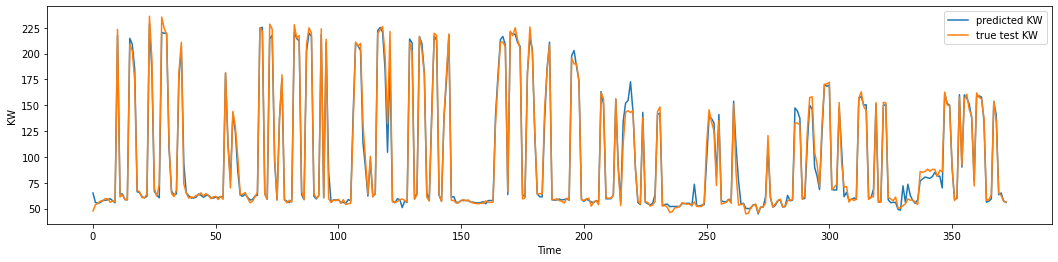

In [19]:
plot_predictions(prediction_compare_a.predicted_kw, prediction_compare_a.true_kw)

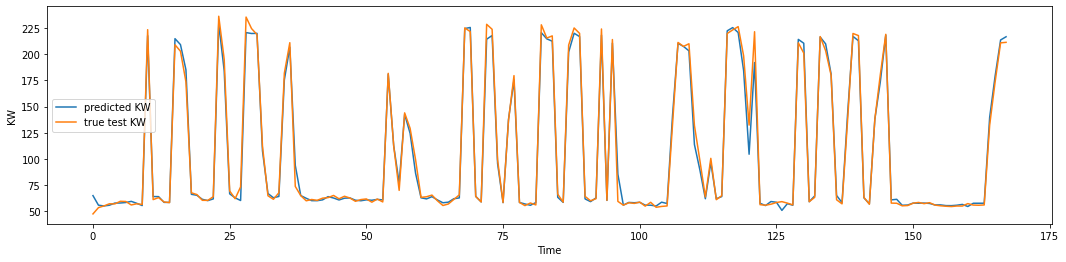

In [21]:
a = 0
b = 24 * 7
plot_predictions(prediction_compare_a.predicted_kw[a:b], prediction_compare_a.true_kw[a:b])

#### Standard Error Metrics

In [22]:
rmse2_a = np.sqrt(mean_squared_error(prediction_compare_a.true_kw, prediction_compare_a.predicted_kw))
nrmse2_a = (rmse2_a / prediction_compare_a.true_kw.max()) * 100

print("RMSE: ", rmse2_a)
print("nRMSE (in %): ", nrmse2_a)

RMSE:  6.10735565170082
nRMSE (in %):  2.587224593393133


#### Split B:

In [23]:
# Join the label with the rest of the data.
prediction_compare_b = X_test_b.copy()
prediction_compare_b['predicted_kw'] = y_pred_b
prediction_compare_b['true_kw'] = y_test_b

# Sort by index to get more readable plots.
prediction_compare_b = prediction_compare_b.sort_index().reset_index(drop=True)
prediction_compare_b.head()

,solar_global,solar_direct,solar_diff_down,pressure,temp,month,day,hour,weekday,holiday,predicted_kw,true_kw
0,0.0,0.0,0.0,998.202885,5.417873,1,18,0,5,0,57.788661,53.174501
1,0.0,0.0,0.0,997.961847,5.189848,1,18,1,5,0,57.809579,52.902479
2,0.0,0.0,0.0,997.639944,5.359470,1,18,2,5,0,57.377591,53.652887
3,0.0,0.0,0.0,997.096906,5.117276,1,18,3,5,0,58.007484,56.919172
4,0.0,0.0,0.0,996.381975,4.572529,1,18,4,5,0,58.563655,58.389289


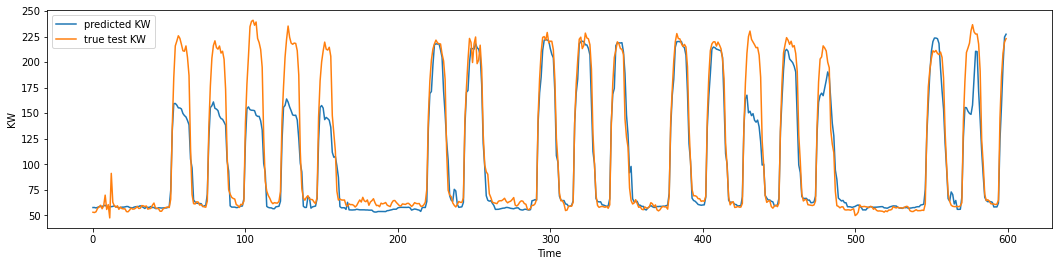

In [24]:
plot_predictions(prediction_compare_b.predicted_kw, prediction_compare_b.true_kw)

In [25]:
rmse2_b = np.sqrt(mean_squared_error(prediction_compare_b.true_kw, prediction_compare_b.predicted_kw))
nrmse2_b = (rmse2_b / prediction_compare_b.true_kw.max()) * 100

print("RMSE: ", rmse2_b)
print("nRMSE (in %): ", nrmse2_b)

RMSE:  24.132490150015297
nRMSE (in %):  10.016072534244085


In [28]:
def plot_categorical_days(prediction_compare_df):
    plt.figure(figsize=(18, 4))
    plt.plot(prediction_compare_df.weekday, label='day of the week')
    plt.plot(prediction_compare_df.holiday, label='day is a holidy')
    plt.plot(prediction_compare_df.true_kw / 50, label='true KW rescaled')
    plt.plot(prediction_compare_df.predicted_kw / 50, label='predicted KW rescaled')
    plt.xlabel('Time')
    plt.legend()
    plt.show()

#### Analyse KW Consumption over Workdays
If we plot the workdays (converted to index representation) over the power consumtion, we see a very clear correlation. On day 5 and 6, which are the weekend days, there is a major drop in power consumtion. This gets prdicted by the model quite well. However we also see that a full week was prdicted at 70% of the actual power consumption. As this is not fluctuating, we assume that the time variables might have a strange impact.

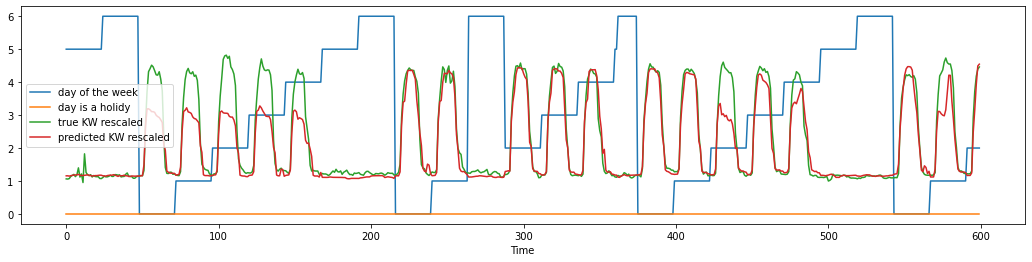

In [29]:
plot_categorical_days(prediction_compare_b)

## Done